## **서울시 따릉이 대여량 예측 경진대회**

### **서울시 마포구의 시간별 기상상황과 따릉이 대여 수 데이터**

* id 고유 id
* hour 시간
* temperature 기온
* precipitation 비가 오지 않았으면 0, 비가 오면 1
* windspeed 풍속(평균)
* humidity 습도
* visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* ozone 오존
* pm10 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* pm2.5 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count 시간에 따른 따릉이 대여 수

In [1]:
# 필요한 라이브러리 import하기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from xgboost import XGBRegressor, plot_tree, plot_importance
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb

from scipy.stats import randint, uniform
from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

### **데이터 살펴보기**

In [2]:
# 데이터 불러오기
train = pd.read_csv('bike_data/train.csv') 
test = pd.read_csv('bike_data/test.csv')

In [3]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [4]:
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [5]:
print(train.shape)
print(test.shape)

(1459, 11)
(715, 10)


train 데이터가 열의 개수가 하나 더 많은 것을 확인할 수 있다. (타겟인 count 포함)

#### **상관관계 확인**

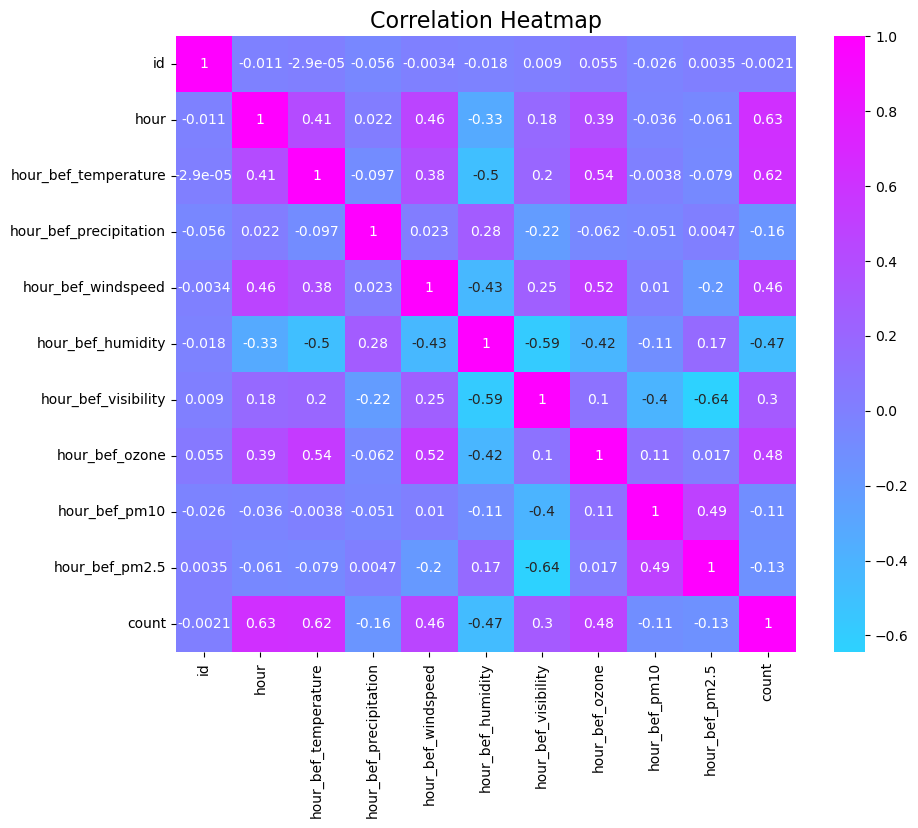

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True, cmap='cool', center=0)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

#### **각 변수들의 분포 확인**

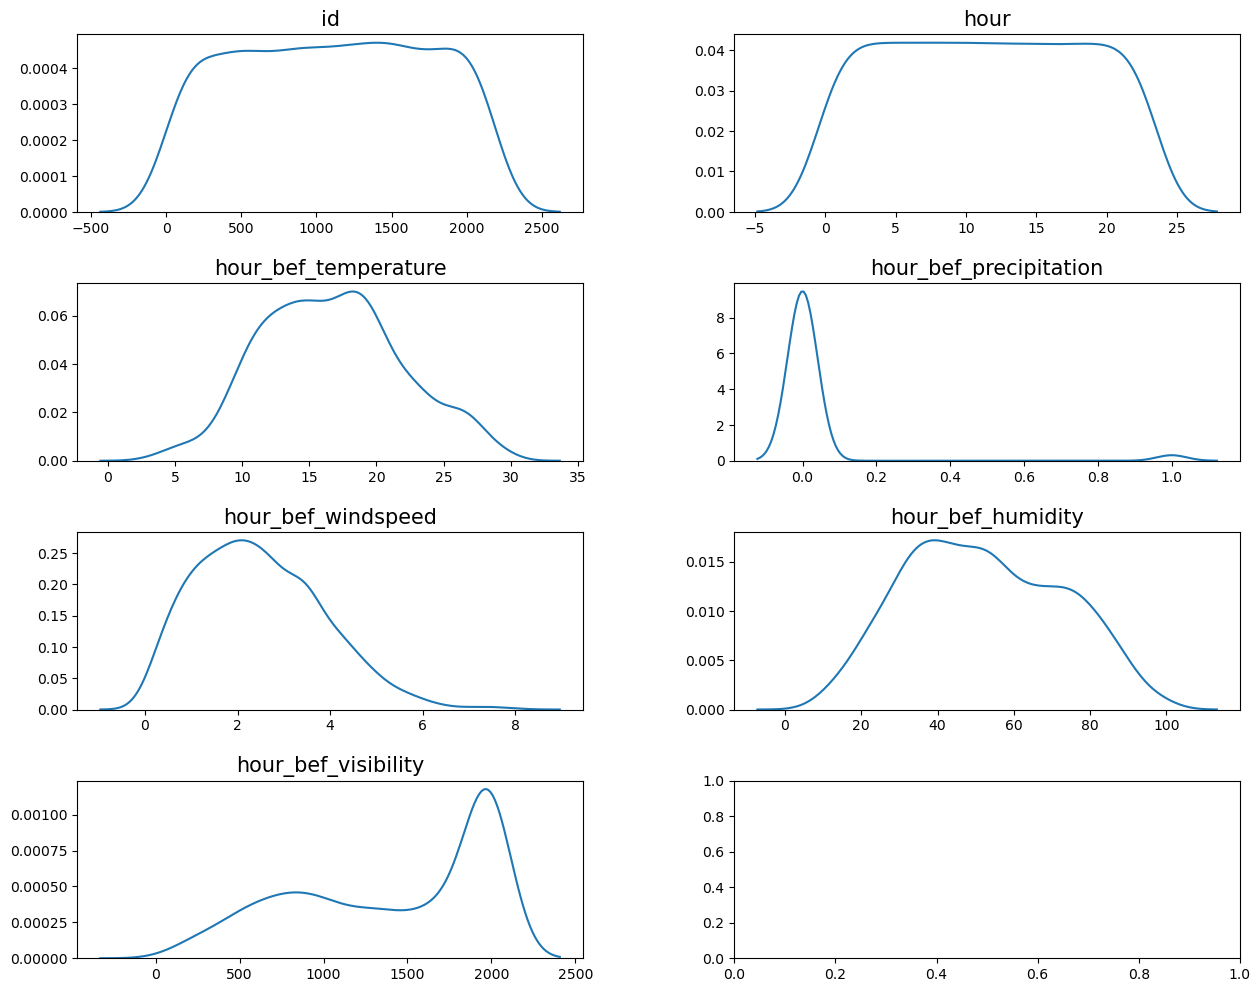

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

count = 0
columns = train.columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        ax[row][col].set_xlabel('')
        ax[row][col].set_ylabel('')
        count += 1
        if count == 7:
            break

hour_bef_visibilty의 경우 그래프가 한쪽으로 쏠려있는 것을 확인할 수 있어 log 변환을 시도해보기로 했다.

#### **시간대별 대여량 분석**

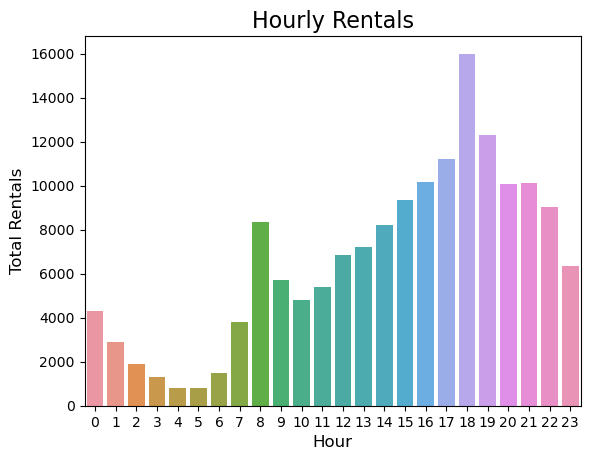

In [8]:
hourly_rentals = train.groupby('hour')['count'].sum().reset_index()
sns.barplot(x='hour', y='count', data=hourly_rentals)
plt.title('Hourly Rentals', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Total Rentals', fontsize=12)
plt.show()

대여량이 8시, 18시에 갑자기 증가하는 것을 확인할 수 있다.
<br>이를 토대로 출퇴근, 등하교 시간에 대여량이 증가한다고 추측할 수 있을 것 같다.

#### **비에 관한 분석**

In [9]:
rainy_hours = train[train['hour_bef_precipitation']==1.0]['hour_bef_precipitation'].count()
non_rainy_hours = train[train['hour_bef_precipitation']==0.0]['hour_bef_precipitation'].count()

print(f'비가 온 시간 : {rainy_hours}')
print(f'비가 안 온 시간 : {non_rainy_hours}')

비가 온 시간 : 46
비가 안 온 시간 : 1411


비가 안 온 시간 대비 비가 온 시간의 데이터 수가 약 30배 차이나는 것을 확인할 수 있다.

In [10]:
rainy_rentals = train[train['hour_bef_precipitation']==1.0]['count'].sum()
non_rainy_rentals = train[train['hour_bef_precipitation']==0.0]['count'].sum()

print(f'비가 온 시간의 대여량: {rainy_rentals}')
print(f'비가 안 온 시간의 대여량: {non_rainy_rentals}')

비가 온 시간의 대여량: 1549.0
비가 안 온 시간의 대여량: 156805.0


비가 온 시간과 안 온 시간의 대여량 차이 또한 매우 크다는 것을 알 수 있다.

### **데이터 전처리**

In [11]:
# 학습 데이터에서 라벨 제거하기
y = train['count']
del train['count']

print(train.columns)

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5'],
      dtype='object')


In [12]:
# 학습 데이터와 테스트 데이터 합치기
train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))

2174


In [13]:
data.reset_index(drop=True, inplace=True)

In [14]:
data.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2174 entries, 0 to 2173
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2174 non-null   int64  
 1   hour                    2174 non-null   int64  
 2   hour_bef_temperature    2171 non-null   float64
 3   hour_bef_precipitation  2171 non-null   float64
 4   hour_bef_windspeed      2164 non-null   float64
 5   hour_bef_humidity       2171 non-null   float64
 6   hour_bef_visibility     2171 non-null   float64
 7   hour_bef_ozone          2063 non-null   float64
 8   hour_bef_pm10           2047 non-null   float64
 9   hour_bef_pm2.5          2021 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 170.0 KB


모두 실수 또는 정수 자료형으로, 문제 없이 모델 학습에 활용할 수 있을 것 같다.

#### **로그 변환**

<Axes: >

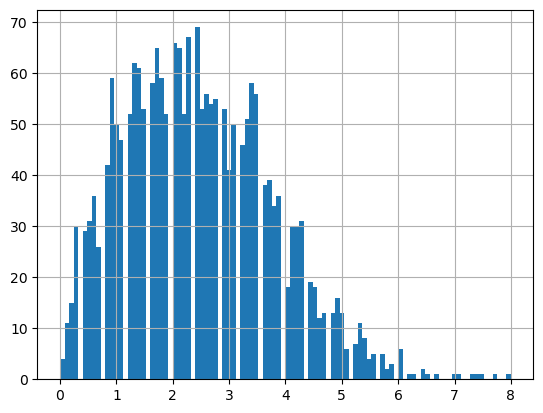

In [16]:
data['hour_bef_windspeed'].hist(bins=100)

In [17]:
print(data['hour_bef_windspeed'][:3])
print(np.log1p(data['hour_bef_windspeed'])[:3])
print(np.expm1(np.log1p(data['hour_bef_windspeed'])[:3])) # 로그로 치환하고 다시 반환하면 문제x

0    1.5
1    1.4
2    0.7
Name: hour_bef_windspeed, dtype: float64
0    0.916291
1    0.875469
2    0.530628
Name: hour_bef_windspeed, dtype: float64
0    1.5
1    1.4
2    0.7
Name: hour_bef_windspeed, dtype: float64


<Axes: >

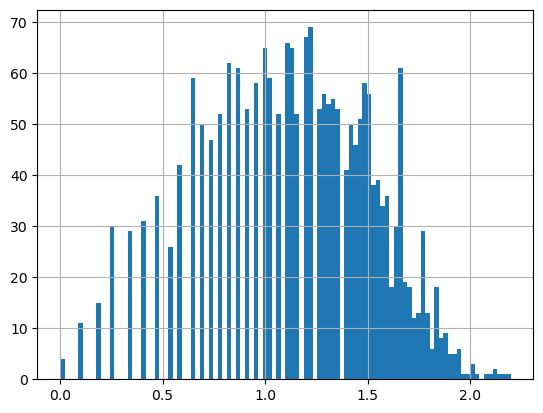

In [18]:
data['hour_bef_windspeed'] = np.log1p(data['hour_bef_windspeed'])
data['hour_bef_windspeed'].hist(bins=100)

비교적 완만한 정규분포의 형태로 잘 변환된 것을 확인할 수 있다.

#### **결측치 확인**

In [19]:
data.isna().sum()

id                          0
hour                        0
hour_bef_temperature        3
hour_bef_precipitation      3
hour_bef_windspeed         10
hour_bef_humidity           3
hour_bef_visibility         3
hour_bef_ozone            111
hour_bef_pm10             127
hour_bef_pm2.5            153
dtype: int64

적지 않은 양의 결측치가 있는 것을 확인할 수 있다.
<br>우리는 이 결측지들을 각 피처의 시간대별 평균값으로 대체해주기로 하였다.

#### **결측치 처리**

In [20]:
# hour_bef_temperature 결측치 확인
data[data['hour_bef_temperature'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2112,1943,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


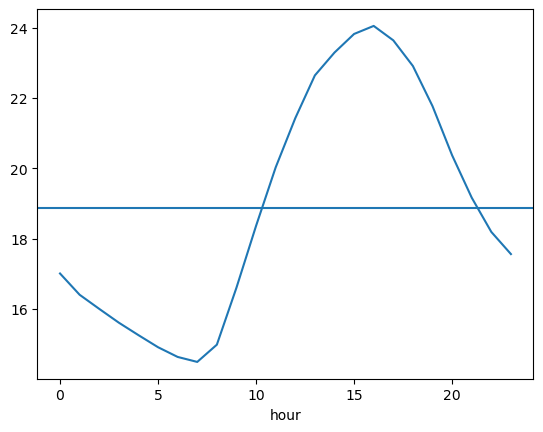

In [21]:
# 시간별 평균 온도 시각화
data.groupby('hour').mean()['hour_bef_temperature'].plot()
plt.axhline(data.groupby('hour').mean()['hour_bef_temperature'].mean())

In [22]:
data.groupby('hour').mean()['hour_bef_temperature']

hour
0     17.012360
1     16.407692
2     16.006593
3     15.614286
4     15.260440
5     14.916667
6     14.640659
7     14.498901
8     14.989011
9     16.608791
10    18.365934
11    20.027473
12    21.426374
13    22.642222
14    23.291209
15    23.819780
16    24.048315
17    23.638202
18    22.908989
19    21.768889
20    20.371429
21    19.167416
22    18.193407
23    17.563736
Name: hour_bef_temperature, dtype: float64

In [23]:
# 결측치 채우기
data['hour_bef_temperature'].fillna(data.groupby('hour')['hour_bef_temperature'].transform('mean'), inplace=True)

In [24]:
# hour_bef_windspeed 결측치 확인
data[data['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
18,33,13,22.600000,0.0,NaN,41.0,987.0,0.046,64.0,39.0
244,381,1,14.100000,0.0,NaN,55.0,1992.0,NaN,NaN,NaN
260,404,3,14.000000,0.0,NaN,50.0,2000.0,0.049,35.0,22.0
376,570,0,14.300000,0.0,NaN,49.0,2000.0,0.044,37.0,20.0
780,1196,20,16.500000,0.0,NaN,31.0,2000.0,0.058,39.0,18.0
934,1420,0,17.012360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,1553,18,22.908989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1138,1717,12,21.400000,0.0,NaN,44.0,1375.0,0.044,61.0,37.0
1229,1855,2,14.000000,0.0,NaN,52.0,2000.0,0.044,37.0,20.0
2112,1943,19,21.768889,NaN,NaN,NaN,NaN,NaN,NaN,NaN


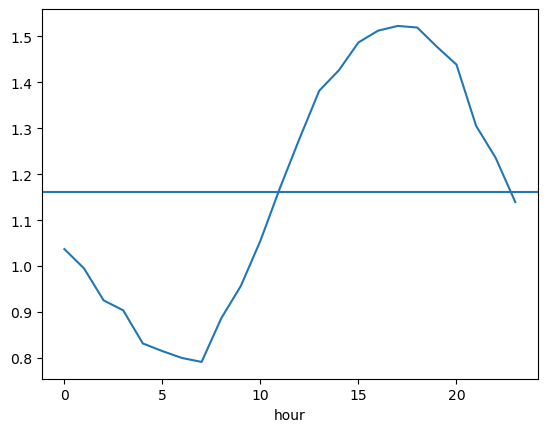

In [25]:
# 시간별 평균 풍속 시각화
data.groupby('hour').mean()['hour_bef_windspeed'].plot()
plt.axhline(data.groupby('hour').mean()['hour_bef_windspeed'].mean())

In [26]:
data.groupby('hour').mean()['hour_bef_windspeed']

hour
0     1.036953
1     0.995054
2     0.925317
3     0.903631
4     0.831585
5     0.814867
6     0.799907
7     0.791350
8     0.886235
9     0.956694
10    1.055261
11    1.170394
12    1.278153
13    1.381746
14    1.426127
15    1.486843
16    1.512366
17    1.522738
18    1.519188
19    1.477455
20    1.438494
21    1.305333
22    1.235356
23    1.139319
Name: hour_bef_windspeed, dtype: float64

In [27]:
# 결측치 채우기
data['hour_bef_windspeed'].fillna(data.groupby('hour')['hour_bef_windspeed'].transform('mean'), inplace=True)

In [28]:
data.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      3
hour_bef_windspeed          0
hour_bef_humidity           3
hour_bef_visibility         3
hour_bef_ozone            111
hour_bef_pm10             127
hour_bef_pm2.5            153
dtype: int64

hour_bef_temperature와 hour_bef_windspeed의 결측치가 사라진 것을 확인할 수 있다.
<br>나머지 피처들도 진행해보자.

In [29]:
# hour_bef_ozone 결측치 확인
data[data['hour_bef_ozone'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
14,28,1,20.000000,0.0,1.029619,58.0,2000.0,NaN,NaN,NaN
44,76,17,21.700000,0.0,1.386294,35.0,2000.0,NaN,32.0,19.0
46,78,1,12.200000,0.0,1.386294,49.0,1071.0,NaN,NaN,NaN
84,130,1,9.400000,0.0,1.252763,65.0,1907.0,NaN,NaN,NaN
122,181,16,26.200000,0.0,1.667707,31.0,1718.0,NaN,47.0,23.0
...,...,...,...,...,...,...,...,...,...,...
2112,1943,19,21.768889,NaN,1.477455,NaN,NaN,NaN,NaN,NaN
2117,1959,14,28.200000,0.0,1.029619,51.0,1814.0,NaN,25.0,18.0
2153,2104,1,21.700000,0.0,0.993252,75.0,957.0,NaN,NaN,NaN
2169,2148,1,24.600000,0.0,1.223775,60.0,1745.0,NaN,NaN,NaN


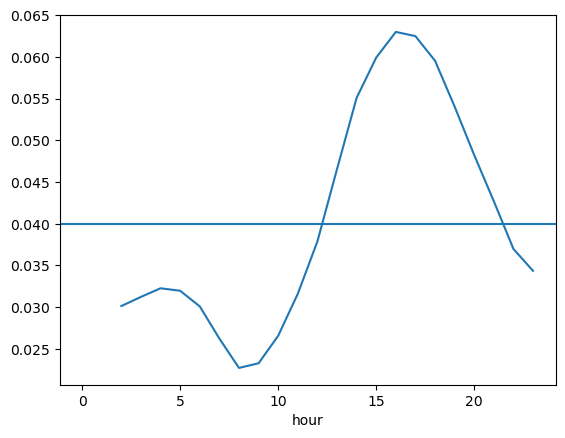

In [30]:
# 시간별 평균 오존 시각화
data.groupby('hour').mean()['hour_bef_ozone'].plot()
plt.axhline(data.groupby('hour').mean()['hour_bef_ozone'].mean())

In [31]:
data.groupby('hour').mean()['hour_bef_ozone']

hour
0     0.032472
1          NaN
2     0.030132
3     0.031231
4     0.032264
5     0.031967
6     0.030089
7     0.026233
8     0.022714
9     0.023275
10    0.026567
11    0.031600
12    0.037878
13    0.046545
14    0.055090
15    0.059921
16    0.063000
17    0.062494
18    0.059545
19    0.054044
20    0.048231
21    0.042697
22    0.036978
23    0.034352
Name: hour_bef_ozone, dtype: float64

In [32]:
# 결측치 채우기
data['hour_bef_ozone'].fillna(data.groupby('hour')['hour_bef_ozone'].transform('mean'), inplace=True)

In [33]:
data.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      3
hour_bef_windspeed          0
hour_bef_humidity           3
hour_bef_visibility         3
hour_bef_ozone             91
hour_bef_pm10             127
hour_bef_pm2.5            153
dtype: int64

hour_bef_ozone의 결측치가 아직 남아있는 것으로 보인다.
<br>나머지 결측치는 1시에 해당하는 값이므로 0시와 2시의 평균 값으로 대체해주기로 했다.

In [34]:
data.loc[data['hour'] == 1, 'hour_bef_ozone'] = 0.031

In [35]:
data.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      3
hour_bef_windspeed          0
hour_bef_humidity           3
hour_bef_visibility         3
hour_bef_ozone              0
hour_bef_pm10             127
hour_bef_pm2.5            153
dtype: int64

hour_bef_ozone 피처에 더 이상 결측치가 없는 것을 확인할 수 있다.

In [36]:
# hour_bef_humidity 결측치 확인
data[data['hour_bef_humidity'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
934,1420,0,17.012360,NaN,1.036953,NaN,NaN,0.032472,NaN,NaN
1035,1553,18,22.908989,NaN,1.519188,NaN,NaN,0.059545,NaN,NaN
2112,1943,19,21.768889,NaN,1.477455,NaN,NaN,0.054044,NaN,NaN


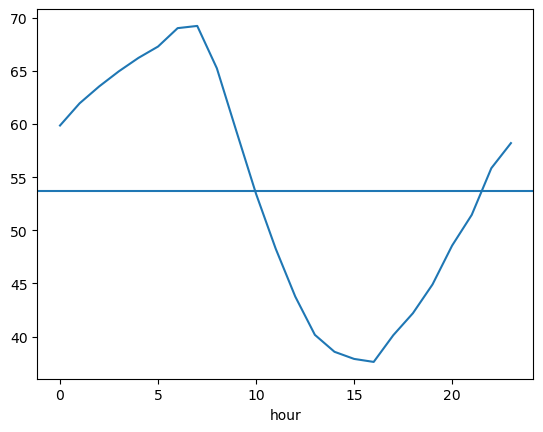

In [37]:
data.groupby('hour').mean()['hour_bef_humidity'].plot()
plt.axhline(data.groupby('hour').mean()['hour_bef_humidity'].mean())

In [38]:
data.groupby('hour').mean()['hour_bef_humidity']

hour
0     59.865169
1     61.956044
2     63.549451
3     64.967033
4     66.230769
5     67.300000
6     69.032967
7     69.241758
8     65.252747
9     59.307692
10    53.428571
11    48.274725
12    43.758242
13    40.155556
14    38.560440
15    37.890110
16    37.606742
17    40.123596
18    42.191011
19    44.900000
20    48.560440
21    51.449438
22    55.846154
23    58.208791
Name: hour_bef_humidity, dtype: float64

In [39]:
# 결측치 채우기
data['hour_bef_humidity'].fillna(train.groupby('hour')['hour_bef_humidity'].transform('mean'), inplace=True)

In [40]:
data[data['hour_bef_humidity'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
2112,1943,19,21.768889,NaN,1.477455,NaN,NaN,0.054044,NaN,NaN


얘는 왜 채워지지 않는 것인가,,, 그냥 지정해서 채워주자!

In [41]:
data.at[2112, 'hour_bef_humidity'] = 44.9

In [42]:
data.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      3
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         3
hour_bef_ozone              0
hour_bef_pm10             127
hour_bef_pm2.5            153
dtype: int64

In [43]:
# hour_bef_precipitation 결측치 확인
data[data['hour_bef_precipitation'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
934,1420,0,17.012360,NaN,1.036953,58.169492,NaN,0.032472,NaN,NaN
1035,1553,18,22.908989,NaN,1.519188,40.450000,NaN,0.059545,NaN,NaN
2112,1943,19,21.768889,NaN,1.477455,44.900000,NaN,0.054044,NaN,NaN


hour_bef_precipitation 경우 위에서 확인해본 결과 비가 안 오는 날의 대여량이 많아 결측치를 0으로 채워주기로 했다.

In [44]:
data['hour_bef_precipitation'].fillna(value = 0.0, inplace=True)

In [45]:
data.isna().sum()

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      0
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         3
hour_bef_ozone              0
hour_bef_pm10             127
hour_bef_pm2.5            153
dtype: int64

#### **변수 정리**

In [46]:
# 불필요한 컬럼 삭제
sub_id = data['id'][train_len:]
data.drop(['id', 'hour_bef_visibility', 'hour_bef_pm10', 'hour_bef_pm2.5'], axis=1, inplace=True)

print(data.columns)

Index(['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_ozone'],
      dtype='object')


In [47]:
print(data.shape)

(2174, 6)


In [48]:
data.isna().sum()

hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_ozone            0
dtype: int64

#### **이상치 제거**

이상치 확인을 위해 모든 피처의 박스플롯 그려보기로 했다.

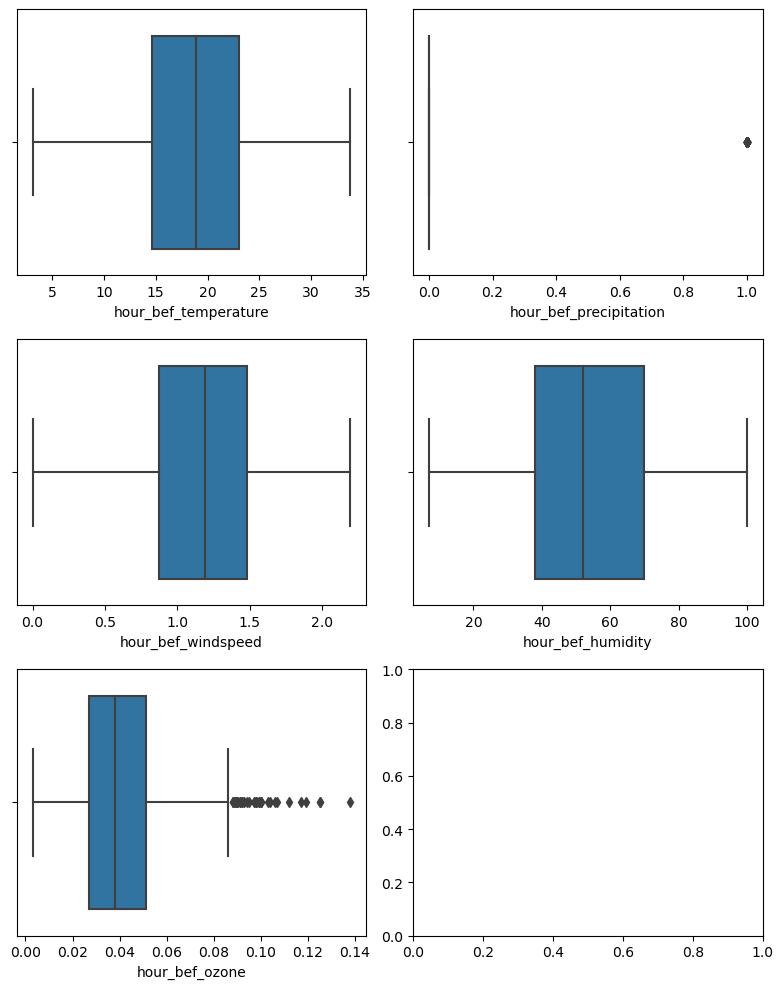

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
for ax, column in zip(axes.flatten(), data.columns[1:]):
    sns.boxplot(x=column, data=data, ax=ax)
plt.tight_layout()
plt.show()

<br>z-score를 사용하여 이상치를 판별하고 0으로 대체하기로 했다.

In [50]:
ozone = data['hour_bef_ozone']

# 평균과 표준편차 계산
mean = np.mean(ozone)
std = np.std(ozone)

# Z-score 계산
z_scores = (ozone - mean) / std
z_scores

# 이상치 탐지 (Z-score가 3보다 크거나 -3보다 작은 값들을 이상치로 판단)
outliers = np.where((z_scores > 3) | (z_scores < -3))[0] # 보통 2 아니면 3으로 설정
print("이상치 인덱스:", outliers)

이상치 인덱스: [ 117  118  292  362  641 1215 1427 1430 1466 1474 1497 1608 1622 1949
 1964]


In [51]:
idx_list = [117, 118, 292, 362, 641, 1215, 1427, 1430, 1466, 1474, 1497, 1608, 1622, 1949, 1964]

for idx in idx_list:
    data.loc[idx, 'hour_bef_ozone'] = 0.0

In [52]:
data.loc[[117, 118, 292, 362, 641, 1215, 1427, 1430, 1466, 1474, 1497, 1608, 1622, 1949, 1964], :]

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone
117,15,28.4,0.0,1.808289,43.0,0.0
118,20,22.7,0.0,1.410987,41.0,0.0
292,16,29.0,0.0,1.629241,41.0,0.0
362,15,29.6,0.0,1.252763,22.0,0.0
641,16,30.0,0.0,1.435085,16.0,0.0
1215,19,24.4,0.0,1.526056,39.0,0.0
1427,18,28.1,0.0,1.686399,25.0,0.0
1430,17,29.2,0.0,1.589235,25.0,0.0
1466,18,31.2,0.0,1.163151,42.0,0.0
1474,14,28.4,0.0,1.410987,43.0,0.0


모두 0.0으로 잘 대체된 것을 확인할 수 있다.

#### **피처 엔지니어링**

이번에는 hour를 활용하여 time_slot이라는 새로운 범주형 변수를 생성해주기로 했다.

In [53]:
# 시간대를 범주형 변수로 변환
bins = [0, 6, 12, 18, 24]  # 0-6시, 6-12시, 12-18시, 18-24시
labels = ['dawn', 'morning', 'afternoon', 'afternoon/evening']
data['time_slot'] = pd.cut(data['hour'], bins=bins, labels=labels, include_lowest=True)
data.head()

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,time_slot
0,20,16.3,1.0,0.916291,89.0,0.027,afternoon/evening
1,13,20.1,0.0,0.875469,48.0,0.042,afternoon
2,6,13.9,0.0,0.530628,79.0,0.033,dawn
3,23,8.1,0.0,1.308333,54.0,0.040,afternoon/evening
4,18,29.5,0.0,1.757858,7.0,0.057,afternoon


In [54]:
# 범주형 변수 원-핫 인코딩
data = pd.get_dummies(data, columns=['time_slot'])
display(data.head())

,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,time_slot_dawn,time_slot_morning,time_slot_afternoon,time_slot_afternoon/evening
0,20,16.3,1.0,0.916291,89.0,0.027,0,0,0,1
1,13,20.1,0.0,0.875469,48.0,0.042,0,0,1,0
2,6,13.9,0.0,0.530628,79.0,0.033,1,0,0,0
3,23,8.1,0.0,1.308333,54.0,0.040,0,0,0,1
4,18,29.5,0.0,1.757858,7.0,0.057,0,0,1,0


In [55]:
# 전체 데이터 다시 나누기
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

print(train.shape)
print(test.shape)

(1459, 10)
(715, 10)


이제 모델 학습을 위한 모든 준비가 완료되었다!

### **모델 정의 및 학습**

In [56]:
# rmse 함수 정의
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [57]:
# random state 값 고정시키기
random_state = 18

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
extrees = ExtraTreesRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest, extrees]

In [58]:
# get_scores 함수 정의
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측 
        y_pred = model.predict(X_test)
        
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # dataframe에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [59]:
get_scores(models, train, y)

,RMSE
XGBRegressor,38.809865
LGBMRegressor,38.739018
GradientBoostingRegressor,37.480700
ExtraTreesRegressor,37.215812
RandomForestRegressor,36.311253


### **교차 검증**

In [60]:
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
         {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}, {'model':extrees, 'name':'ExtraTrees'} ]

In [61]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=18, shuffle = True).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)), kf=kfold))

In [62]:
get_cv_score(models)

Model GradientBoosting CV score : 0.7455
Model XGBoost CV score : 0.7356
Model LightGBM CV score : 0.7471
Model RandomForest CV score : 0.7493
Model ExtraTrees CV score : 0.7406


### **Make Submission**

In [63]:
def AveragingBlending(models, train, y, test):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [64]:
y_pred = AveragingBlending(models, train, y, test)

In [65]:
test = pd.DataFrame(data={'id':sub_id,'count':y_pred})

In [66]:
test.to_csv('submission.csv', index=False)

### **최종 점수**

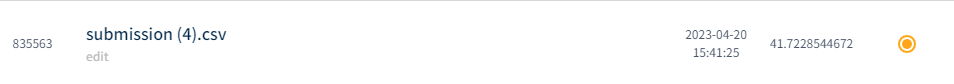